# 1D Burgers’ Equation - PyTorch

Based on https://www.marktechpost.com/2025/03/28/a-step-by-step-guide-to-solve-1d-burgers-equation-with-physics-informed-neural-networks-pinns-a-pytorch-approach-using-automatic-differentiation-and-collocation-methods/

## Install requirements

In [8]:
%%bash
source $HOME/conda/bin/activate pt
conda env list


# conda environments:
#
base                   /home/x/conda
jll                    /home/x/conda/envs/jll
mech                   /home/x/conda/envs/mech
mkdocs                 /home/x/conda/envs/mkdocs
ocrmypdf               /home/x/conda/envs/ocrmypdf
pt                   * /home/x/conda/envs/pt
tf2                    /home/x/conda/envs/tf2
udocker                /home/x/conda/envs/udocker



In [9]:
%%bash
source $HOME/conda/bin/activate pt
conda install matplotlib

Retrieving notices: done
Channels:
 - conda-forge
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /home/x/conda/envs/pt

  added / updated specs:
    - matplotlib


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    alsa-lib-1.2.14            |       hb9d3cd8_0         553 KB  conda-forge
    contourpy-1.3.2            |  py312h68727a3_0         270 KB  conda-forge
    cycler-0.12.1              |     pyhd8ed1ab_1          13 KB  conda-forge
    cyrus-sasl-2.1.27          |       h54b06d7_7         214 KB  conda-forge
    double-conversion-3.3.1    |       h5888daf_0          68 KB  conda-forge
    fonttools-4.58.0           |  py312h178313f_0         2.7 MB  conda-forge
    kiwisolver-1.4.8           |  py312h84d6215_0          70 KB  conda-forge
    libclang-cpp19.1-19.1.2    |default_hb5137d0_1        19.6 MB  conda-forge
    libclang13-19.1.2   

## Main

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Set the default tensor type to float32 for compatibility with numerical operations
torch.set_default_dtype(torch.float32)

# Define physical parameters and boundaries
x_min, x_max = -1.0, 1.0  # Spatial range
t_min, t_max = 0.0, 1.0   # Temporal range
nu = 0.01 / np.pi         # Diffusion coefficient

# Define the number of sampled points
N_f = 10000  # Collocation points for the partial differential equation (PDE)
N_0 = 200    # Initial condition points
N_b = 200    # Boundary condition points

# Generate collocation points for training the PINN
X_f = np.random.rand(N_f, 2)  # Generate random points in a 2D space
X_f[:, 0] = X_f[:, 0] * (x_max - x_min) + x_min  # Normalize x to [-1, 1]
X_f[:, 1] = X_f[:, 1] * (t_max - t_min) + t_min  # Normalize t to [0, 1]

# Initial condition u(x, 0) = -sin(pi * x)
x0 = np.linspace(x_min, x_max, N_0)[:, None]  # Discretized spatial domain
t0 = np.zeros_like(x0)  # Fixed initial time (t = 0)
u0 = -np.sin(np.pi * x0)  # Sine function applied to initial condition

# Boundary conditions u(-1,t) = 0 and u(1,t) = 0
tb = np.linspace(t_min, t_max, N_b)[:, None]  # Time points for boundary
xb_left = np.ones_like(tb) * x_min  # Left boundary position (x = -1)
xb_right = np.ones_like(tb) * x_max # Right boundary position (x = 1)
ub_left = np.zeros_like(tb)  # Function value at the left boundary
ub_right = np.zeros_like(tb) # Function value at the right boundary

# Check if a GPU is available to accelerate computations
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert data to PyTorch tensors and move them to GPU if available
X_f = torch.tensor(X_f, dtype=torch.float32, requires_grad=True).to(device)
x0 = torch.tensor(x0, dtype=torch.float32).to(device)
t0 = torch.tensor(t0, dtype=torch.float32).to(device)
u0 = torch.tensor(u0, dtype=torch.float32).to(device)
tb = torch.tensor(tb, dtype=torch.float32).to(device)
xb_left = torch.tensor(xb_left, dtype=torch.float32).to(device)
xb_right = torch.tensor(xb_right, dtype=torch.float32).to(device)
ub_left = torch.tensor(ub_left, dtype=torch.float32).to(device)
ub_right = torch.tensor(ub_right, dtype=torch.float32).to(device)

In [6]:
# Define the PINN neural network using PyTorch
class PINN(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.activation = nn.Tanh()  # Non-linear activation function
        self.layers = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) - 1)])
       
    def forward(self, x):
        """Defines the flow of data through the neural network."""
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))  # Apply activation function in hidden layers
        return self.layers[-1](x)  # Final layer without activation (output u(x,t))

# Initialize the model and move to GPU if available
layers = [2, 50, 50, 50, 50, 1]  # Network structure: input (x, t), 4 hidden layers, output u(x,t)
model = PINN(layers).to(device)

In [7]:
torch.cuda.is_available()

True

In [8]:
# Function to compute the residual of the partial differential equation using autograd
def pde_residual(model, X):
    x = X[:, 0:1]
    t = X[:, 1:2]
    u = model(torch.cat([x, t], dim=1))

    # Compute derivatives using PyTorch's autograd mechanism
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
   
    # PDE residual: u_t + u * u_x - nu * u_xx = 0
    f = u_t + u * u_x - nu * u_xx
    return f

In [9]:
# Loss function combining multiple constraints
def loss_func(model):
    loss_f = torch.mean(pde_residual(model, X_f)**2)  # PDE loss
    loss_0 = torch.mean((model(torch.cat([x0, t0], dim=1)) - u0)**2)  # Initial condition loss
    loss_b = torch.mean(model(torch.cat([xb_left, tb], dim=1))**2) + torch.mean(model(torch.cat([xb_right, tb], dim=1))**2)  # Boundary condition loss
    return loss_f + loss_0 + loss_b

PyTorch needs a CUDA context to be explicitly initialized. PyTorch uses cuBLAS for GPU computations and needs an active CUDA context:

Ensure CUDA is initialized before running PyTorch operations:

In [13]:
torch.cuda.init()

Run a dummy tensor operation before training to force CUDA initialization:

In [14]:
dummy = torch.tensor(1.0).cuda()
print(torch.cuda.is_initialized())  # Should return True

True


Check if PyTorch detects the GPU:

In [15]:
print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.cuda.device_count())  # Number of GPUs detected
print(torch.cuda.current_device())  # Current active GPU
print(torch.cuda.get_device_name(torch.cuda.current_device()))  # GPU name

True
1
0
NVIDIA GeForce RTX 3050


## Training

In [16]:
# Configure the Adam optimizer for adjusting the network's weights
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop for the PINN
num_epochs = 5000
for epoch in range(num_epochs):
    optimizer.zero_grad()  # Reset accumulated gradients
    loss = loss_func(model)  # Compute the total loss
    loss.backward()  # Compute gradients via backpropagation
    optimizer.step()  # Update parameters based on computed gradients

    # Print loss every 500 epochs to track progress
    if (epoch+1) % 500 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.5e}')

print("Training complete!")

Epoch 500/5000, Loss: 9.02352e-02
Epoch 1000/5000, Loss: 8.31379e-02
Epoch 1500/5000, Loss: 7.72399e-02
Epoch 2000/5000, Loss: 7.08830e-02
Epoch 2500/5000, Loss: 6.16532e-02
Epoch 3000/5000, Loss: 1.68226e-01
Epoch 3500/5000, Loss: 1.66871e-02
Epoch 4000/5000, Loss: 7.59026e-03
Epoch 4500/5000, Loss: 4.57896e-03
Epoch 5000/5000, Loss: 3.58485e-03
Training complete!


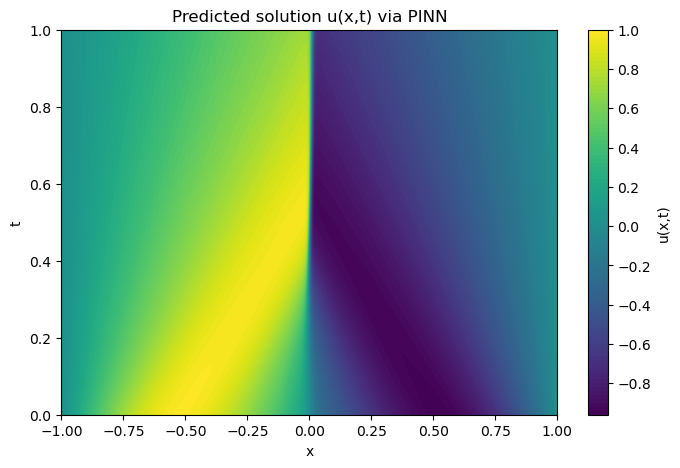

In [17]:
# Evaluate the model
model.eval()

# Generate a grid for visualization
N_x, N_t = 256, 100
x = np.linspace(x_min, x_max, N_x)
t = np.linspace(t_min, t_max, N_t)
X, T = np.meshgrid(x, t)
XT = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
XT_tensor = torch.tensor(XT, dtype=torch.float32).to(device)

# Compute the predicted solution using the trained model
with torch.no_grad():
    u_pred = model(XT_tensor).cpu().numpy().reshape(N_t, N_x)

# Plot the predicted solution
plt.figure(figsize=(8, 5))
plt.contourf(X, T, u_pred, levels=100, cmap='viridis')
plt.colorbar(label='u(x,t)')
plt.xlabel('x')
plt.ylabel('t')
plt.title("Predicted solution u(x,t) via PINN")
plt.show()